## NLP: Spam detection in SMS using DL

Text classification using Dense network. LSTM and Bi-LSTM architectures in TensorFlow2



## Introduction
Today, internet and social media have become the fastest and easiest ways to get information. In this age, reviews, opinions, feedbacks, messages and recommendations have become significant source of information. Thanks to advancement in technologies, we are now able to extract meaningful information from such data using various Natural Language Processing (NLP) techniques. NLP , a branch of Artificial Intelligence (AI), makes use of computers and human natural language to output valuable information. NLP is commonly used in text classification task such as spam detection and sentiment analysis, text generation, language translations and document classification.

## Purpose
The purpose of this article is to understand how we can use TensorFlow2 to build SMS spam detection model. Particularly, we will build a binary classification model to detect whether a text message is spam or not (aka Ham). Moreover, we’ll learn how to implement Dense, Long Short Term Memory (LSTM) and Bidirectional-LSTM (Bi-LSTM) deep learning models in TensorFlow2 Keras API.

## Data
The SMS (text) data was downloaded from UCI datasets. It contains 5,574 SMS phone messages. The data were collected for the purpose of mobile phone spam research and have already been labeled as either spam or ham.

## Method
We will use Dense text classifier , LSTM and Bi-LSTM and compare these methods in terms of performance and select a final one.

#### Below are the sections that we cover in this article:

- Load and explore the spam data
- Prepare train test data
- Train the spam detection model using the three approaches mentioned above
- Compare and select a final model
- Use the final trained classifier to classify the new messages
- Let’s get started, first making sure the version of TensrFlow.



### 2.1 Import Data and Required Packages
####  Importing Pandas, Numpy, Matplotlib, Seaborn and wordcloud.

In [4]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [5]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional


#### Load and explore the spam data
The data can be dowloaded from UCI datasets and saved in a local folder. The text file (and a complete Jupyter notebook) is also provided in my github location hence can be read using below syntax. The text file is a tab separated (\t) file hence, we can use pandas to read data as a dataframe. We can also provide the columns name by passing names, call it label and message.

In [6]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])

In [7]:
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


Let’s get the summary statistics and visualize the data. The describe() method from pandas provide a summary statistics. Such as, there are 5,572 labels and messages. There are two unique labels indicating for “ham” and “spam”. We can also observe that there are less unique messages (5,169) than total message count(5,572) indicating some repeated messages. The top label is “ham” and the top message in the data is “Sorry, I’ll call later”. The duplicatedRow below shows, there are 403 duplicated messages.

In [8]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
messages.shape

(5572, 2)

#### Summary Statistics Below

In [10]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


#### Duplicated Row  &darr;

In [11]:
duplicateRow = messages[messages.duplicated()]
print(duplicateRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


There are 4,825 ham compared to 747 spam messages. This indicates the imbalanced data which we will fix later. The most popular ham message is “Sorry, I’ll call later”, whereas the most popular spam message is “Please call our customer service…” which occurred 30 and 4 times, respectively.

##### Summary statistic by labels (ham or spam) &darr;

In [12]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

Below, we further explore the data by label groups by creating a WordCloud and a bar chart. First, let’s create a separate dataframe for ham and spam message and convert it to numpy array to generate WordCloud.

In [13]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

#### To visualize using WordCloud(), 
we extract words most commonly found in ham and spam messages, remove meaningless stop words such as “the”, “a” , “is” etc, and plot it. The WordCloud visualizes the most frequent words in the given text.

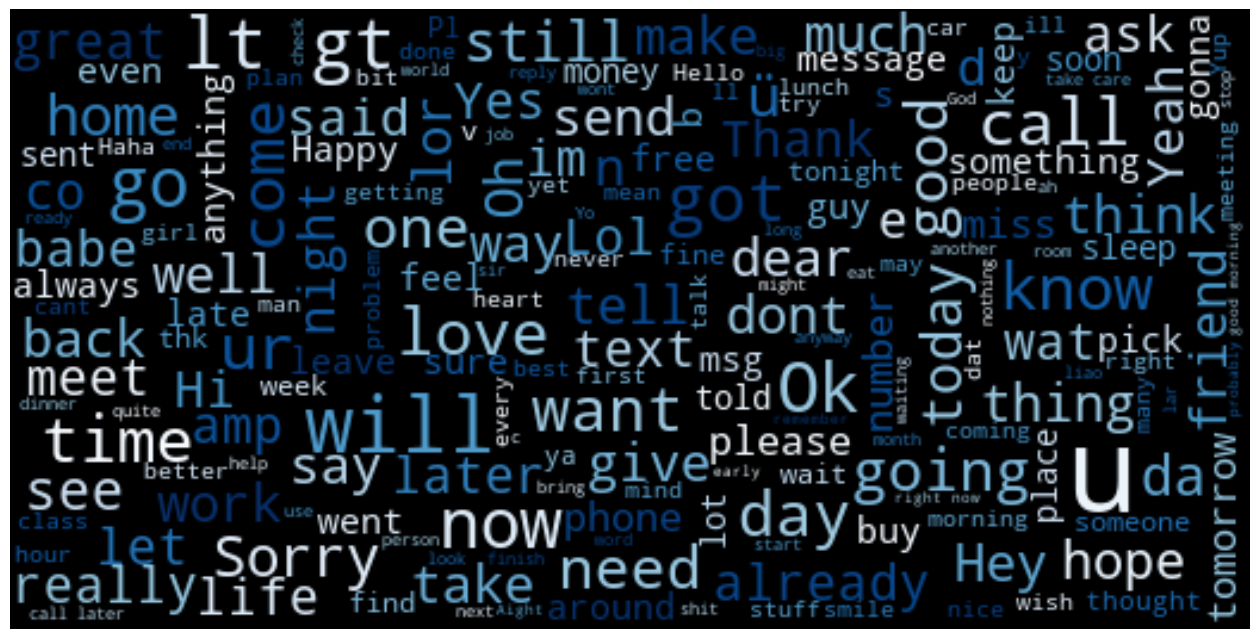

In [14]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The spam message WordCloud below shows that “Free”, “call”, “text”, “claim” and“reply” are most commonly appeared words in spam messages.

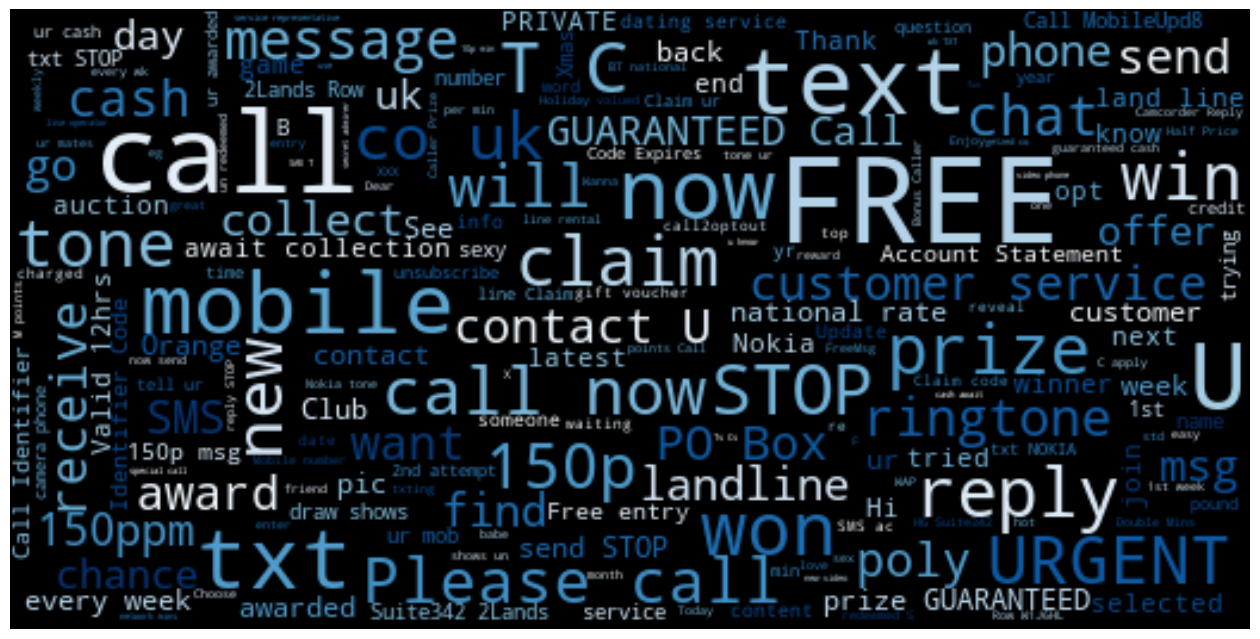

In [15]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

##### Now, let’s further explore the imbalanced data. Below, the bar chart shows that the classes are imbalanced. There are most frequent ham messages (85%) than spam (15%).

15.481865284974095

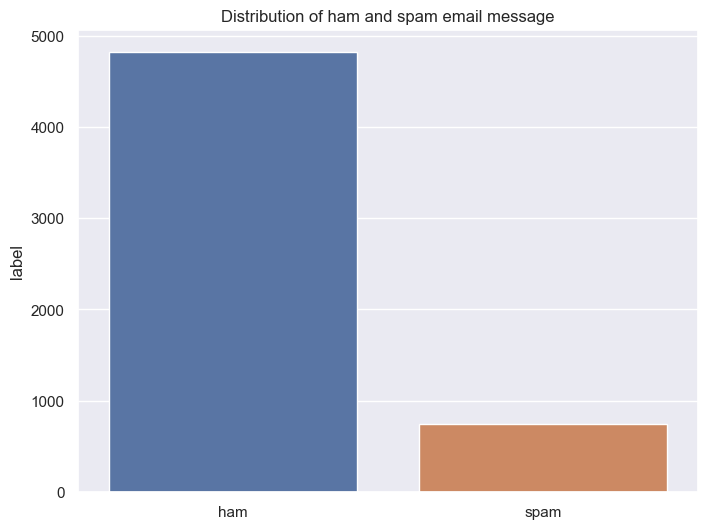

In [16]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
coun_balance=pd.value_counts(messages["label"], sort=True)
sns.barplot(x=coun_balance.index, y=coun_balance)                                 #countplot(messages.label).astype(float)
plt.title('Distribution of ham and spam email message')

# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

## IMBALANCE DATA

There are several ways to handle the imbalance data, for instance
- use of appropriate evaluation metrics
- resampling the training set : oversampling/upsampling or undersampling/downsampling
- ensemble different resample datasets

However, for our problem, we use downsampling just to illustrate how it is implemented. You can of course, try other techniques and compare the results.

Downsampling is a process where you randomly delete some of the observations from the majority class so that the numbers in majority and minority classes are matched. Below, we have downsampled the ham messages (majority class). There are now 747 messages in each class.


In [17]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


#### Below chart shows a similar distribution across message types after accounting for the imbalanced data.

C:\Users\SAMAR\AppData\Local\Temp\ipykernel_5684\1981820002.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


Text(0.5, 0, 'Message types')

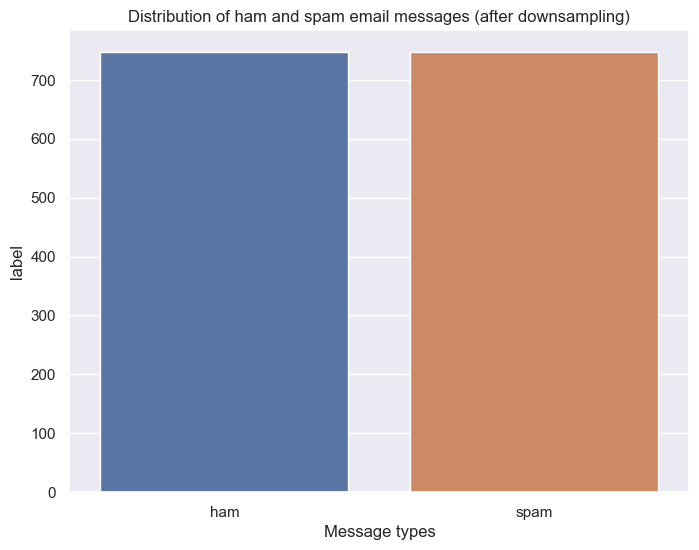

In [18]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
#sns.countplot(msg_df.label)
coun_balance=pd.value_counts(msg_df.label, sort=True)
sns.barplot(x=coun_balance.index, y=coun_balance)     



plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')




Furthermore, on average, the ham message has length of 73 words whereas spam message has 138. The length information may be useful when we set maxlen parameter later.

In [19]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

C:\Users\SAMAR\AppData\Local\Temp\ipykernel_5684\171999825.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  labels = msg_df.groupby('label').mean()


,text_length
label,
ham,73.238286
spam,138.670683



## Prepare train/test data and pre-process text

After exploring and accounting for imbalanced data, next let’s convert the text label to numeric and split the data into training set and testing set. Also, convert label to numpy arrays to fit deep learning models. 80% of data were used for training and 20% for testing purposes.

In [20]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

Now, let’s use text pre-processing which includes Tokenization, Sequencing and Padding.

The figure below depicts an example of a process flow in text pre-processing along with the expected output.

from IPython import display
display.Image("https://miro.medium.com/v2/resize:fit:640/format:webp/1*zsIXWoN0_CE9PXzmY3tIjQ.png")

For basic understanding on pre-processing text data using TensorFlow2, please refer to my previous article on pre-processing data for deep learning model.

### Tokenization

As deep learning models do not understand text, let’s convert text into numerical representation. For this purpose, a first step is Tokenization. The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers. Tokenizer() does all the required pre-processing such as

- tokenize into word or character — here we use at word level
- num_words for maximum number of unique tokens hence we can filter out rare words
- filter out punctuation terms
- convert all words to lower case
- convert all words to integer index

First, define hyper-parameters used for pre-processing. We’ll describe these hyper-parameters later.

In [21]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

Below, we used Tokenizer() to tokenize the words.

In [22]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

Hyper-parameters used in Tokenizer object are: num_words and oov_token, char_level.

- num_words: Indicate how many unique words to load in training and testing data. For our purpose, we selected 500 words (vocab_size)
- oov_token: When its used, out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus during text_to_sequence calls (see below).
- char_level: If it is “True” then every character will be treated as a token. We set it as “False”, hence every word will be treated as a token.

We can get the word_index using tokenizer.word_index. A snapshot of word_index is printed below.

In [23]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [25]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


### Sequencing and Padding

After tokenization, we represent each sentence by sequences of numbers using texts_to_sequences() from tokenizer object. Subsequently, we use pad_sequences() so that each sequence will have same length. Sequencing and padding are done for both training and testing data.

In [24]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

- padding = ‘pre’ or ‘post (default pre). By using pre, we pad before each sequence and by using post we pad after each sequence.
- maxlen = maximum length of all sequences. Here max_len=50 hence, we are only going to use 50 words in a sentence. If not provided, by default it will use the maximum length of the longest sentence.
- truncating = ‘pre’ or ‘post’ (default ‘pre’). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. ‘pre’ option will truncate at the beginning where as ‘post’ will truncate at the end of the sequences.

In [26]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)


Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


Before padding, first sequence is 27 word long where as second one is 24. Once the padding was applied, both sequences have length of 50.

In [27]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [28]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

As depicted below, the padded sequence has length of 50.

In [29]:
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


#####  Dense Spam Detection Model
With our data loaded and preprocessed, we’re now well prepared to use neural network architecture to classify the text message. Let’s train the model using a Dense architecture followed by LSTM and Bi-LSTM.

Define hyper-parameters:

In [30]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

Below is a model architecture of dense spam detection model.

In [31]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

- Sequential calls for Keras sequential model in which layers are added in a sequence
- The first layer i.e. embedding layer maps each word to a N-dimensional vector of real numbers. The embeding_dim is the size of this vector which is 16 in our case. The embedding layer indicates that the two words with a similar meaning tend to have very close vectors. Because, the embedding layer is the first hidden layer in our model network, we need to pass shape of our input layer as defined by input_length (max_len =50).
- The pooling layer helps to reduce the number of parameters in the model hence helps to avoid overfitting. We have used average pooling here and converted layer to 1 dimension.
- Next, we use a dense layer with activation function ‘relu’ followed by a dropout layer to avoid overfitting and a final output layer with sigmoid activation function. As there are only two classes (ham or spam) to classify, we use only a single output neuron. The sigmoid activation function outputs probabilities between 0 and 1.

Here, we use fairly a shallow neural network architecture, however, you can make it more dense adding more layers.
The model.summary() below, provides the layer, shape and number of parameters used in each layer. In the embedding layer, the 8000 parameter comes from 500 words (vocab_size), each one with a 16 dimensional word-vector space (500 X 16 =8000). The embedding layer is passed through GlobalAveragePooling1D and into dense layers have shape of 16 (due to the average pooling along 16 embedding dimension). We selected 24 neurons for the dense hidden layer. Each of the 24 neurons in the dense layer gets input from each of the 16 values coming from the 
##### GlobalAveragePooling1D layer, for a total of 384 (16 X 24) weights and 24 biases (one for each 24 neurons). 
Hence the total parameter is 408. Finally, the output layer has 24 weights (one for each neuron) and its one bias term resulting 25 parameters in total.



In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

## Compiling the Dense model

- Let’s compile our dense spam classifier model. We use ‘binary_crossentropy’ as a loss function because of binary output, ‘adam’ as an optimiser which makes use of momentum to avoid local minima and ‘accuracy’ as a measure of model performance.

In [33]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

## Training and evaluating the Dense model

- Next, let’s fit our dense classifier using model.fit() argument. It uses padded training data and training labels for training the model and validation data for validating.

- epoch: Number of times the learning algorithm will work through the entire training data set. We set it to be 20.
- callbacks: callbacks is used to pass the early stopping parameter. EarlyStopping(monitor=’val_loss’, patience=2) is used to define that we want to monitor the validation loss and if the validation loss is not improved after two epochs, then the model training is stopped. It helps to avoid overfitting problem and indicates when to stop training before the learner begins over-fit. As depicted in the history results below, the validation loss is increased (i.e. not improved), continuously for 2 epochs (epoch 24: 0.12, and epoch 25: 0.13) after epoch 23, hence the model fitting has stopped at epoch 26.
- verbose =2: lets to print loss and accuracy on each epoch


In [34]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 2s - loss: 0.6878 - accuracy: 0.5188 - val_loss: 0.6804 - val_accuracy: 0.6923 - 2s/epoch - 57ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6702 - accuracy: 0.7774 - val_loss: 0.6551 - val_accuracy: 0.8094 - 124ms/epoch - 3ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6306 - accuracy: 0.8301 - val_loss: 0.6031 - val_accuracy: 0.8261 - 131ms/epoch - 3ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5636 - accuracy: 0.8586 - val_loss: 0.5310 - val_accuracy: 0.8428 - 125ms/epoch - 3ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4833 - accuracy: 0.8745 - val_loss: 0.4572 - val_accuracy: 0.8696 - 125ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.4069 - accuracy: 0.9004 - val_loss: 0.3927 - val_accuracy: 0.8595 - 121ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.3372 - accuracy: 0.8987 - val_loss: 0.3358 - val_accuracy: 0.8829 - 120ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2842 - accuracy: 0.9105 - val_loss: 0.2946 - val_accuracy: 0.8896 - 121ms/epoch - 3ms/step
Epoch 9/30
38/38 -

#### The model resulted , training loss: 0.07, training accuracy: 97%, validation loss: 0.13 and validation accuracy: 94%.

In [35]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 3ms/step - loss: 0.1153 - accuracy: 0.9532


[0.11529075354337692, 0.953177273273468]

We can further visualize the history results by plotting loss and accuracy by number of epochs.

In [36]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

Figure below shows, loss over number of epochs for training and validation data sets. As expected, the loss is decreasing as the number of epochs increases. The validation loss is higher than training loss after around 5 epochs and the difference is more pronounced with increase in epochs.

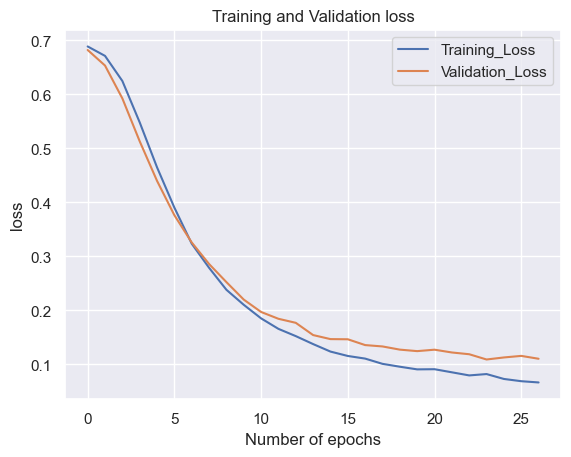

In [63]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

The accuracy plot below shows, the accuracy is increasing over epochs. As expected, the model is performing better in training set than the validation set. If the model performs very well on training data however, its performance is worse in testing data, then it is an indication of overfitting. In our model, we don’t see a significant issue with over-fitting. Moreover, we have accounted for over-fitting problem by using dropout layer and callback earlier.

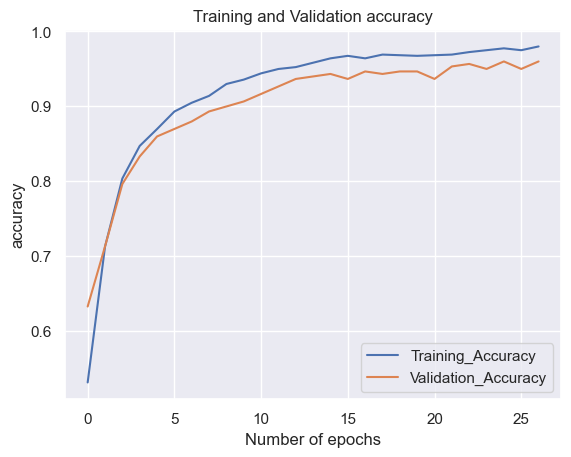

In [64]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

#### Long Short Term Memory (LSTM) Model
Below, we fit the spam detection model using LSTM. Some new hyper-parameters used in LSTM below are n_lstm and return_sequences.
- n_lstm = 20 is the number of nodes in the hidden layers within the LSTM cell
- return_sequences=True ensures that the LSTM cell returns all of the outputs from the unrolled LSTM cell through time. If this argument is not used, the LSTM cell will simply provide the output of the LSTM cell from the previous step.

**** Below are hyper-parameters used for LSTM model.

In [39]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

Let’s define LSTM spam detection model architecture. In Keras, by simply adding LSTM we can fit the LSTM model.

In [51]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

#### Compiling the LSTM model

In [44]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])


Training and evaluation LSTM model

The training and evaluations are same as we did for Dense model above.

In [45]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, 
epochs=num_epochs, validation_data=(testing_padded, 
test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30


ValueError: in user code:

    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 50, 1) vs (None,)).


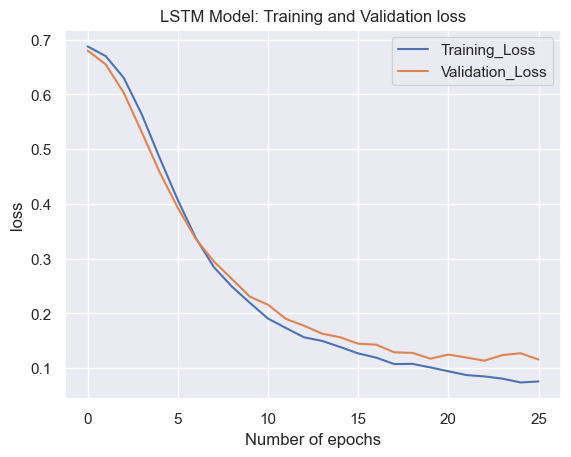

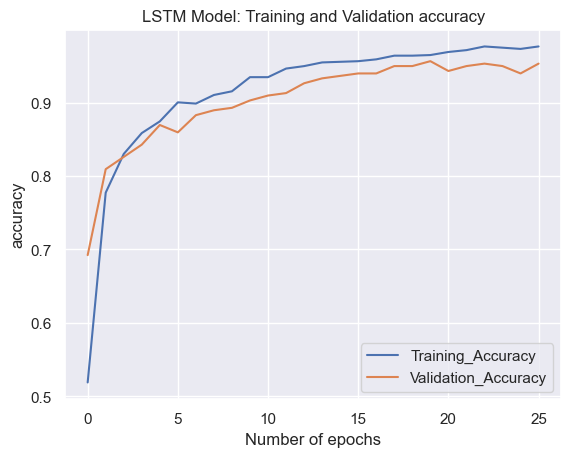

In [52]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')


## Bi-directional Long Short Term Memory (BiLSTM) Model
Unlike in LSTM, the Bi-LSTM learns patterns from both before and after a given token within a document. 
##### The Bi-LSTM back-propagates 
in both backward and forward directions in time. Due to this, the computational time is increased compared to LSTM. However, in most of the cases Bi-LSTM results in better accuracy.

Below, we can see the Bi-directional LSTM architecture, where only difference than LSTM is that we use Bidirectional wrapper to LSTM.

In [53]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

## Compiling the BiLSTM model

In [54]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

## Training and evaluation BiLSTM model

In [55]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30


ValueError: in user code:

    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "e:\Projects\DL-spam-detector\dlenv\lib\site-packages\keras\backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 50, 1) vs (None,)).


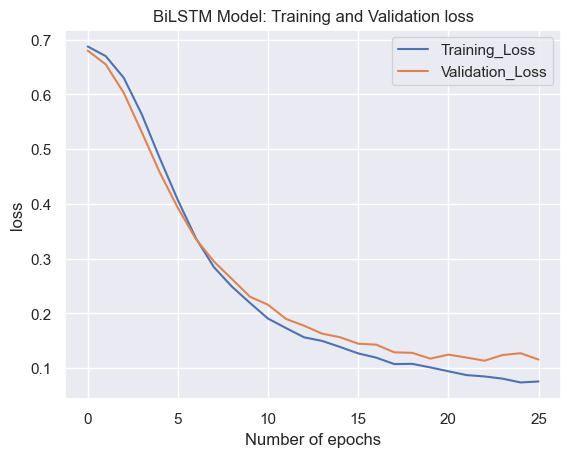

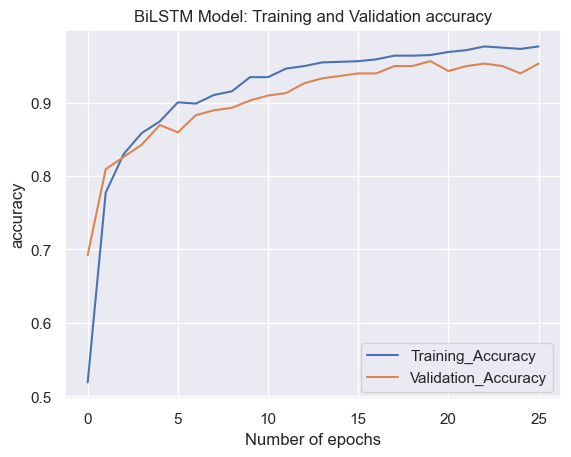

In [56]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Compare three different models and select a final one
All Dense, LSTM and Bi-LSTM models are comparable in terms of loss and accuracy. The validation loss for these three models are 0.13, 0.31 and 0.18, respectively. And, the validation accuracy are 94%, 91% and 95%, respectively.

Among all, both Dense and BiLSTM outperformed the LSTM. Based on loss, accuracy and the plots above, we select Dense architecture as a final model for classifying the text messages for spam or ham. The dense classifier has simple structure and the loss and accuracy over epochs are more stable than in BiLSTM.

In [57]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 2ms/step - loss: 0.1153 - accuracy: 0.9532
Dense architecture loss and accuracy: [0.11529075354337692, 0.953177273273468] 


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

## Predict spam/ham on new messages
##### Scenario 1: Using raw text from our data:

Let’s evaluate how our Dense spam detection model predicts/classifies whether its spam or ham given the text from our original data. First and second messages below are ham whereas the third one is a spam message. We’ve used the same tokenizer that we created earlier in the code to convert them into the sequences. This makes sure the new words will have the same token as in the training set. Once tokenized, we use padding as we did earlier and provide the same dimension as in training set.

In [58]:
# display long string 
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [60]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

predict_spam function is defined as below.

In [61]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 121ms/step


array([[0.01475933],
       [0.00761532],
       [0.9995177 ]], dtype=float32)

#### Scenario 2: Using newly created text message and see how the model classifies them.
Below, first sentence is more like a spam whereas the rest of the two sentences are more like ham.

In [63]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 26ms/step


array([[0.89980084],
       [0.04250414],
       [0.01856513]], dtype=float32)

Our model correctly classifies the first message as spam (94% chance to be spam) were as the rest as ham.

## Summary
We used the text messages from UCI datasets and fit deep learning models such as Dense architecture, LSTM and Bi-LSTM and compared the accuracy and loss on validation set across these models. Finally, we selected the Dense architectural deep learning model to classify text messages as spam or ham and used it to classify new text messages. This article, provides an overview of using different architectural deep learning models to NLP problem using TensorFlow2 Keras.

## Next Step/Improvement
Next, we can explore more sampling approaches such as upsampling, SMOTE, overall sample. We can also try using different hyper-parameters, increase the sample size to improve the model further.

## Acknowledgement!
I would like to thank Jon Krohn for his book “Deep Learning Illustrated”, Lazy programmer Inc for their excellent course “Tensorflow 2.0: Deep Learning and Artificial Intelligence” and Jose Portilla for an awesome course “Complete Tensorflow 2 and Keras Deep Learning Bootcamp” on Udemy.

